In [49]:
!python3 -m pip install ucimlrepo

  Using cached ucimlrepo-0.0.7-py3-none-any.whl.metadata (5.5 kB)
Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.exe -m pip install --upgrade pip


In [50]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [203]:
print(X.head())
columns_extract = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)'
       ,'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4 

In [204]:
data = X[columns_extract].to_numpy()

In [205]:
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)
normalized_data_column = (data - data_min) / (data_max - data_min)

In [206]:
print(data[2000:4000,2])

[-200. -200. -200. ... -200. -200. -200.]


In [88]:
plt.plot(normalized_data_column[:,12])

IndexError: index 13 is out of bounds for axis 1 with size 13

In [230]:
from kan import *
import torch

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
def model_routine(model, dataset):
    model.fit(dataset, opt="LBFGS", steps=10, loss_fn = loss_fn)
    #plot_model(model)
    return model
    
def test_refinment(model, dataset):    
    model = model.refine(10)
    model.fit(dataset, opt="LBFGS", steps=20, loss_fn = loss_fn)
    #plot_model(model)
    return model

In [309]:
def model_refinement(width, dataset):
    pprint = copy.deepcopy(width)
    grids = np.array([3,10,20,35])
    #grids = np.array([50])
    models = []
    train_losses = []
    test_losses = []
    steps = 200
    k = 3
    for i in range(grids.shape[0]):
        print(grids[i])
        if i == 0:
            model = KAN(width=width, grid=grids[i], k=3, seed=0)
        if i != 0:
            model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps, loss_fn = loss_fn)
        train_loss = results['train_loss']
        test_loss = results['test_loss']
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        models.append(model)
        #plot_model(model)
        plt.title(f"Model with Grid size {grids[i]} and compressionshape {pprint}")
        plt.plot(train_loss)
        plt.plot(test_loss)
        plt.legend(['train', 'test'])
        plt.ylabel('RMSE')
        plt.xlabel('step')
        plt.yscale('log')
        path = os.path.join("plots",f"G_{grids[i]}_w_{pprint}_t_{steps}.png"  )
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.show()
    return models, train_losses, test_losses

In [233]:
model = KAN(width=[13,3,13], grid=3, k=3, seed = 2)


checkpoint directory created: ./model
saving model version 0.0


In [209]:
shuffled_data = np.random.permutation(normalized_data_column)
index = int(data.shape[0] * 0.8)

In [210]:
dataset = {
    'train_input':torch.tensor(shuffled_data[:index], dtype = torch.float32),
    'test_input':torch.tensor(shuffled_data[index:], dtype = torch.float32),
    'train_label':torch.tensor(shuffled_data[:index], dtype = torch.float32),
    'test_label':torch.tensor(shuffled_data[index:], dtype = torch.float32)
}

In [211]:
model = model_routine(model, dataset)

| train_loss: 5.46e-02 | test_loss: 5.49e-02 | reg: 2.75e+01 | : 100%|█| 10/10 [00:17<00:00,  1.76s/

saving model version 0.1


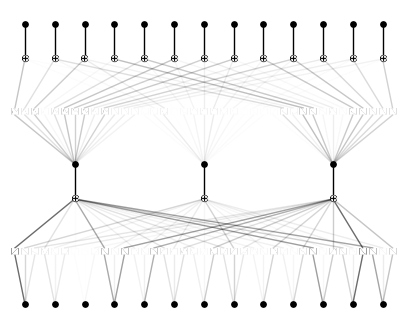

In [212]:
model.plot()

In [213]:
model = test_refinment(model, dataset)

saving model version 0.2


| train_loss: 2.85e-02 | test_loss: 2.87e-02 | reg: 2.79e+01 | : 100%|█| 20/20 [00:48<00:00,  2.44s/

saving model version 0.3


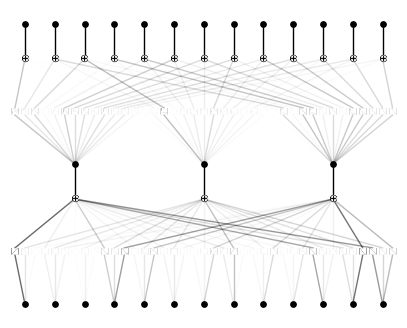

In [214]:
model.plot()

In [277]:
for i in range(10):
    liste = [1,i,i,4]
    print(f"Das ist eine Liste: {liste}")

Das ist eine Liste: [1, 0, 0, 4]
Das ist eine Liste: [1, 1, 1, 4]
Das ist eine Liste: [1, 2, 2, 4]
Das ist eine Liste: [1, 3, 3, 4]
Das ist eine Liste: [1, 4, 4, 4]
Das ist eine Liste: [1, 5, 5, 4]
Das ist eine Liste: [1, 6, 6, 4]
Das ist eine Liste: [1, 7, 7, 4]
Das ist eine Liste: [1, 8, 8, 4]
Das ist eine Liste: [1, 9, 9, 4]


In [296]:
model_dict = {i: None for i in range(1, 14)}

3
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 6.54e-02 | test_loss: 6.67e-02 | reg: 1.67e+01 | : 100%|█| 200/200 [04:10<00:00,  1.25


saving model version 0.1


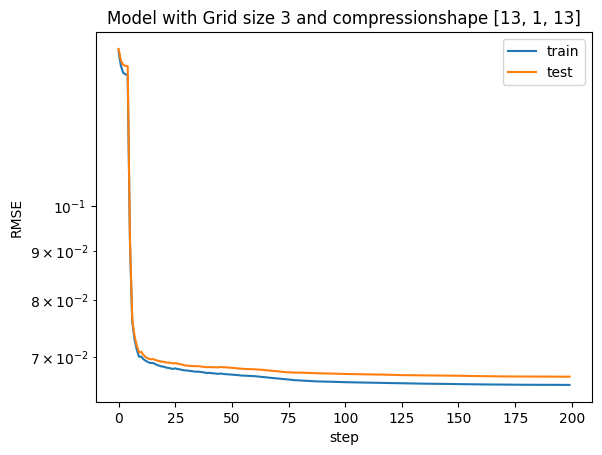

10
saving model version 0.2


| train_loss: 5.90e-02 | test_loss: 6.05e-02 | reg: 1.69e+01 | : 100%|█| 200/200 [06:25<00:00,  1.93


saving model version 0.3


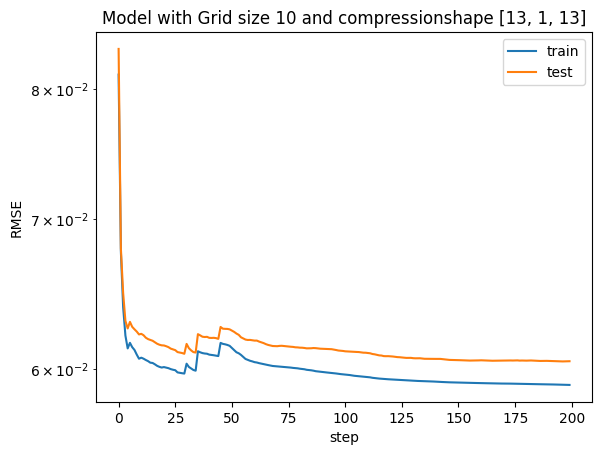

20
saving model version 0.4


| train_loss: 3.18e-01 | test_loss: 2.61e-01 | reg: 1.97e+01 | : 100%|█| 200/200 [08:20<00:00,  2.50


saving model version 0.5


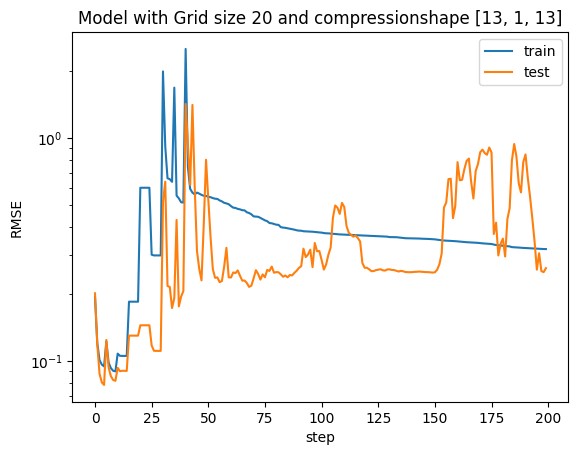

35
saving model version 0.6


| train_loss: 7.19e-02 | test_loss: 2.23e-01 | reg: 1.70e+01 | : 100%|█| 200/200 [12:55<00:00,  3.88


saving model version 0.7


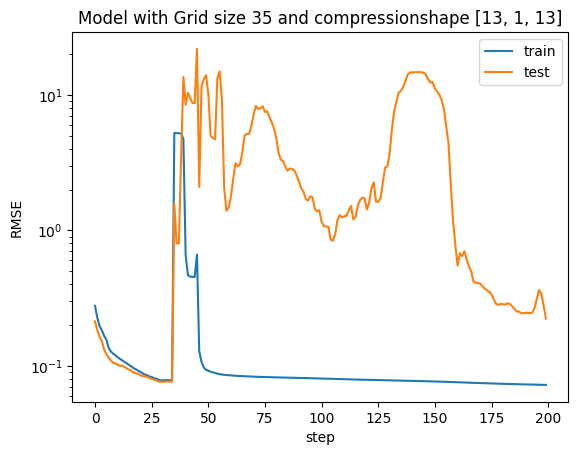

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.13e-02 | test_loss: 4.20e-02 | reg: 2.20e+01 | : 100%|█| 200/200 [05:13<00:00,  1.57


saving model version 0.1


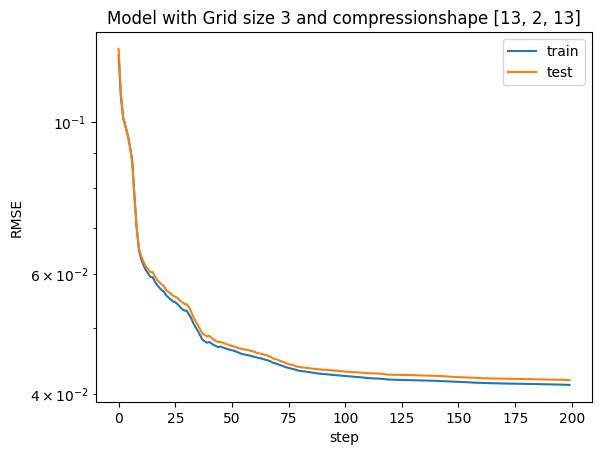

10
saving model version 0.2


| train_loss: 2.86e-02 | test_loss: 2.89e-02 | reg: 2.22e+01 | : 100%|█| 200/200 [07:07<00:00,  2.14


saving model version 0.3


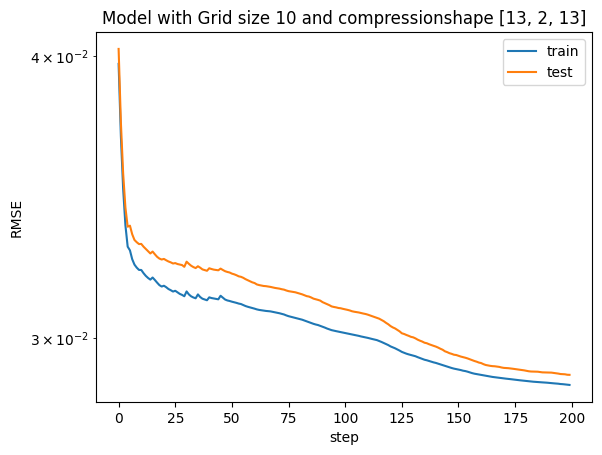

20
saving model version 0.4


| train_loss: 3.74e-02 | test_loss: 4.24e-02 | reg: 2.22e+01 | : 100%|█| 200/200 [10:53<00:00,  3.27


saving model version 0.5


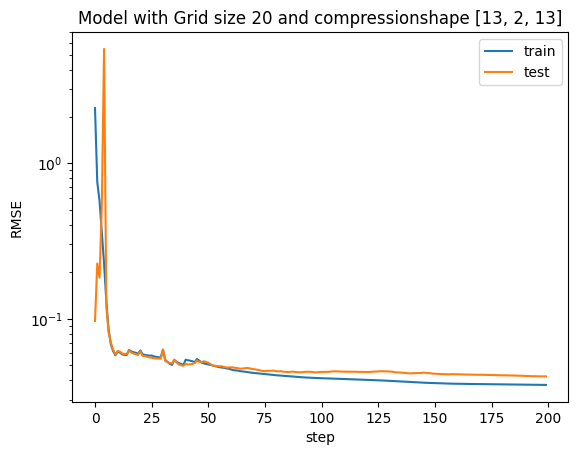

35
saving model version 0.6


| train_loss: 3.66e-02 | test_loss: 9.68e-02 | reg: 2.26e+01 | : 100%|█| 200/200 [14:14<00:00,  4.27


saving model version 0.7


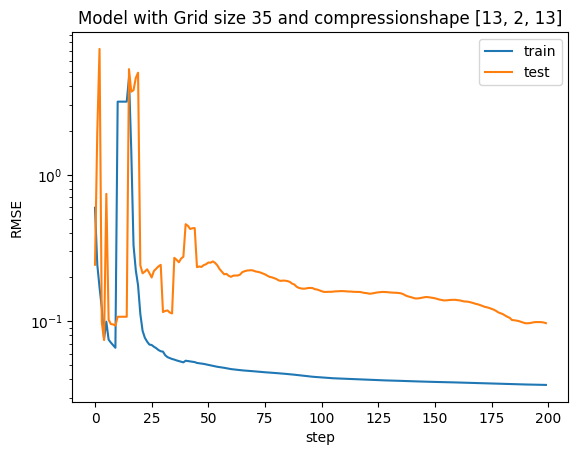

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e-02 | test_loss: 2.68e-02 | reg: 2.76e+01 | : 100%|█| 200/200 [05:37<00:00,  1.69


saving model version 0.1


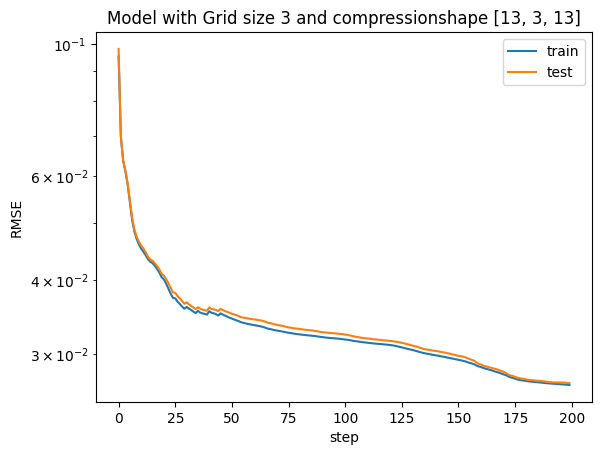

10
saving model version 0.2


| train_loss: 2.19e-02 | test_loss: 2.22e-02 | reg: 2.69e+01 | : 100%|█| 200/200 [07:51<00:00,  2.36


saving model version 0.3


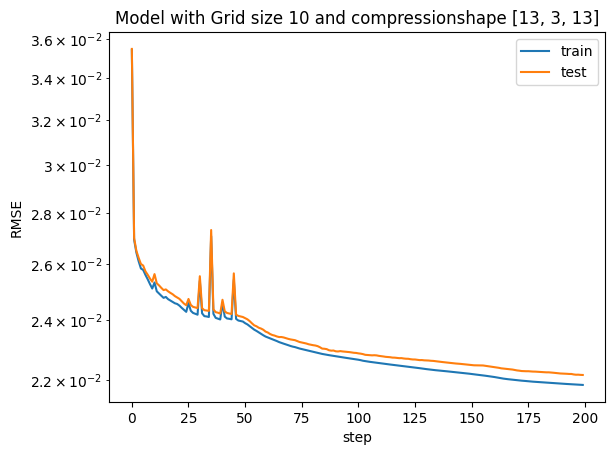

20
saving model version 0.4


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [12:08<00:00,  3.64s/it]


saving model version 0.5


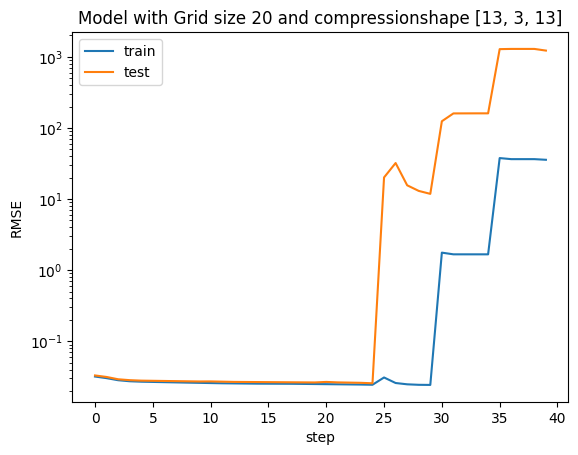

35
saving model version 0.6


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [23:45<00:00,  7.13s/it]


saving model version 0.7


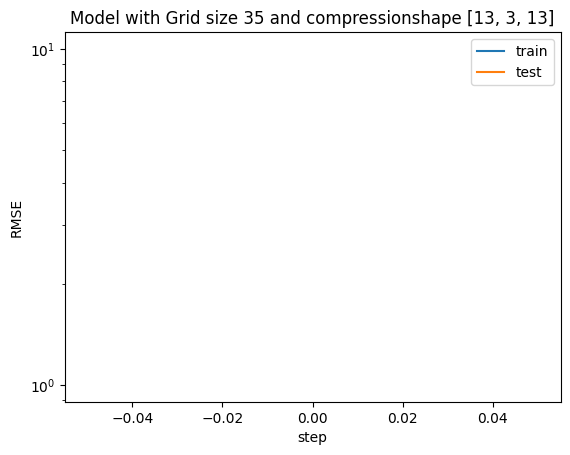

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-02 | test_loss: 2.28e-02 | reg: 3.93e+01 | : 100%|█| 200/200 [06:11<00:00,  1.86


saving model version 0.1


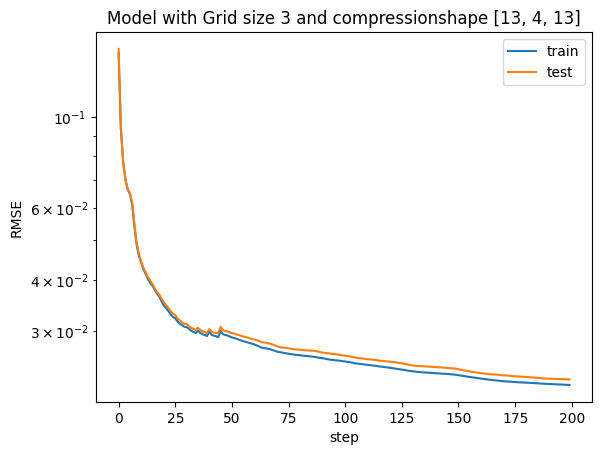

10
saving model version 0.2


| train_loss: 1.67e-02 | test_loss: 1.70e-02 | reg: 3.91e+01 | : 100%|█| 200/200 [08:39<00:00,  2.60


saving model version 0.3


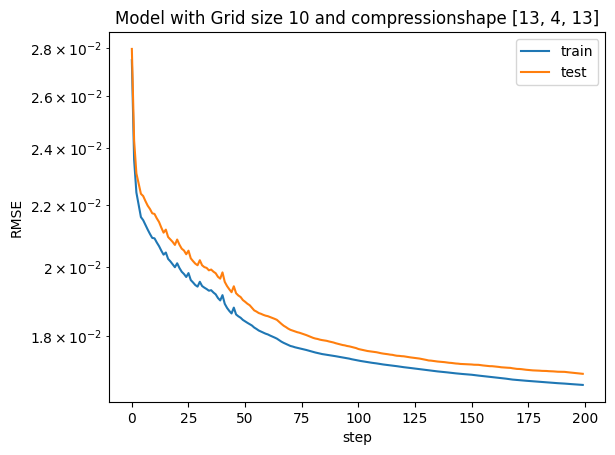

20
saving model version 0.4


| train_loss: 2.42e-02 | test_loss: 5.76e-02 | reg: 3.88e+01 | : 100%|█| 200/200 [08:39<00:00,  2.60


saving model version 0.5


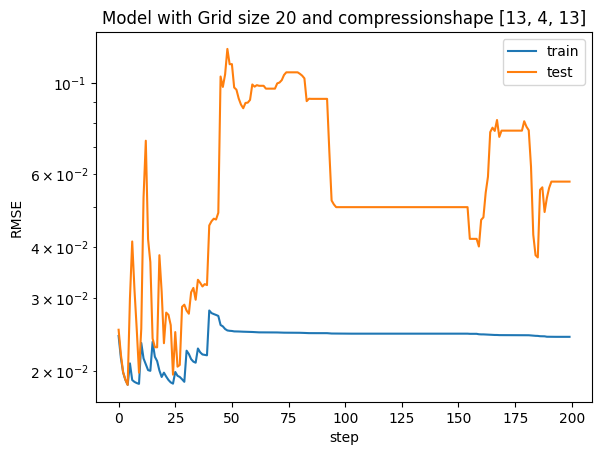

35
saving model version 0.6


| train_loss: 1.53e-02 | test_loss: 1.60e-01 | reg: 3.92e+01 | : 100%|█| 200/200 [18:09<00:00,  5.45


saving model version 0.7


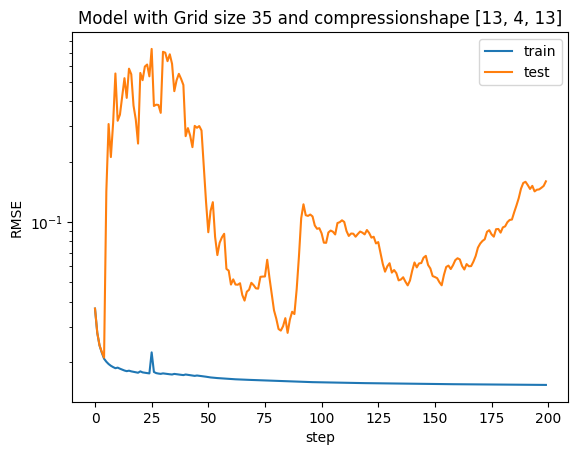

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-02 | test_loss: 1.47e-02 | reg: 3.44e+01 | : 100%|█| 200/200 [06:35<00:00,  1.98


saving model version 0.1


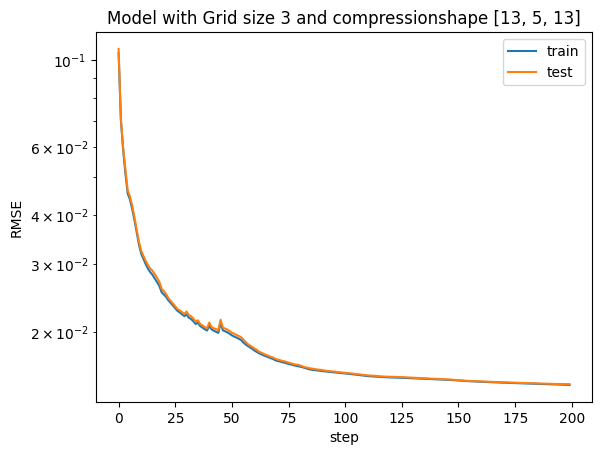

10
saving model version 0.2


| train_loss: 1.22e-02 | test_loss: 1.22e-02 | reg: 3.54e+01 | : 100%|█| 200/200 [09:30<00:00,  2.85


saving model version 0.3


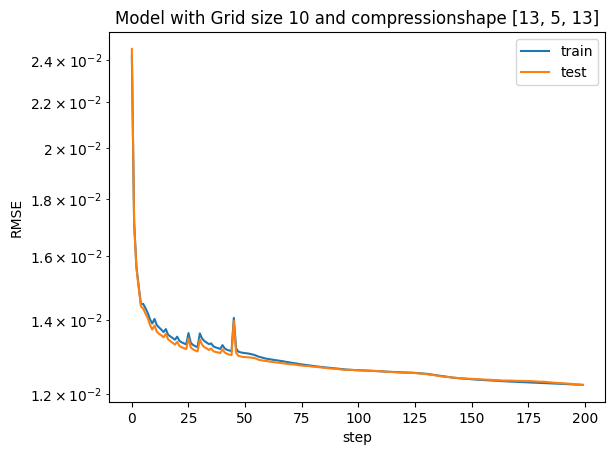

20
saving model version 0.4


| train_loss: 3.07e-02 | test_loss: 3.10e-02 | reg: 3.56e+01 | : 100%|█| 200/200 [05:46<00:00,  1.73


saving model version 0.5


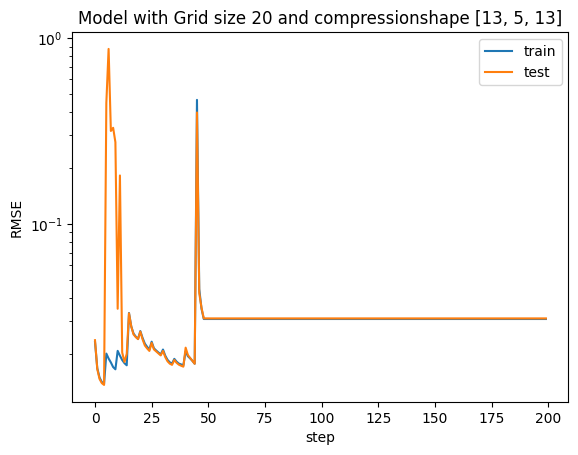

35
saving model version 0.6


| train_loss: 1.67e-02 | test_loss: 1.87e-02 | reg: 6.29e+01 | : 100%|█| 200/200 [20:06<00:00,  6.03


saving model version 0.7


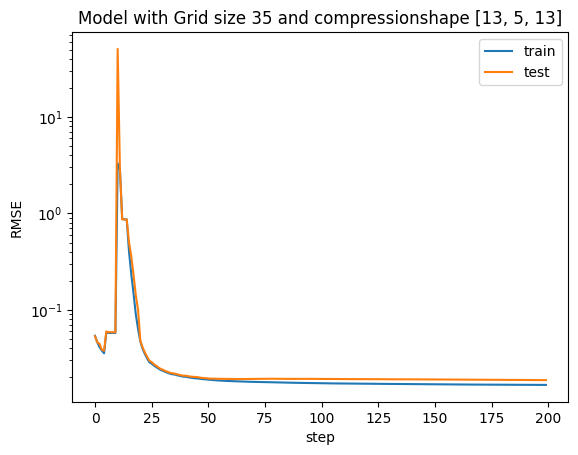

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-02 | test_loss: 1.33e-02 | reg: 4.35e+01 | : 100%|█| 200/200 [07:14<00:00,  2.17


saving model version 0.1


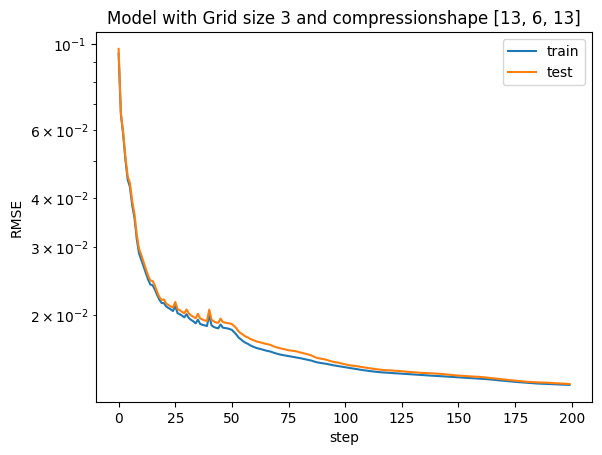

10
saving model version 0.2


| train_loss: 1.29e-02 | test_loss: 8.86e-02 | reg: 4.31e+01 | : 100%|█| 200/200 [10:56<00:00,  3.28


saving model version 0.3


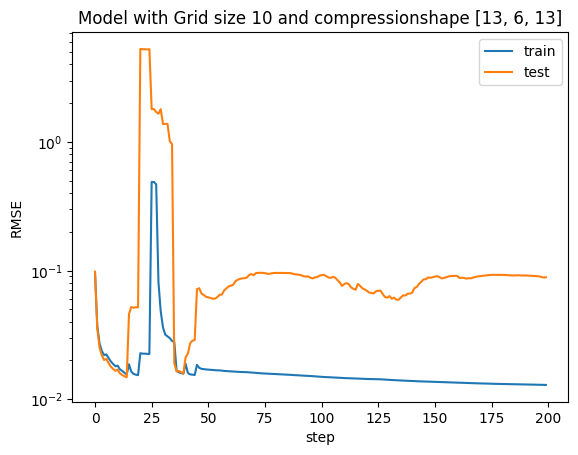

20
saving model version 0.4


| train_loss: 9.89e-03 | test_loss: 1.03e-02 | reg: 3.82e+01 | : 100%|█| 200/200 [14:34<00:00,  4.37


saving model version 0.5


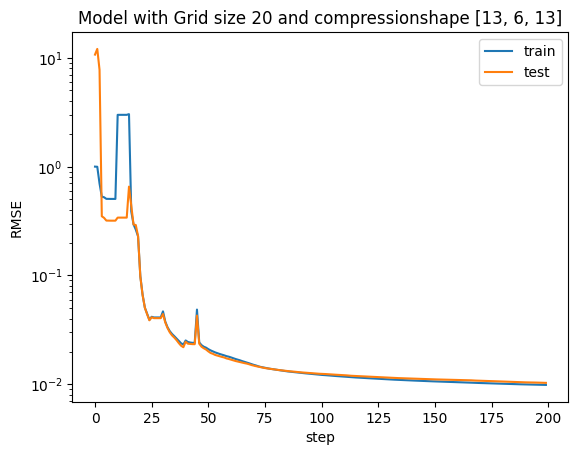

35
saving model version 0.6


| train_loss: 2.37e-02 | test_loss: 2.42e-02 | reg: 3.47e+02 | : 100%|█| 200/200 [22:23<00:00,  6.72


saving model version 0.7


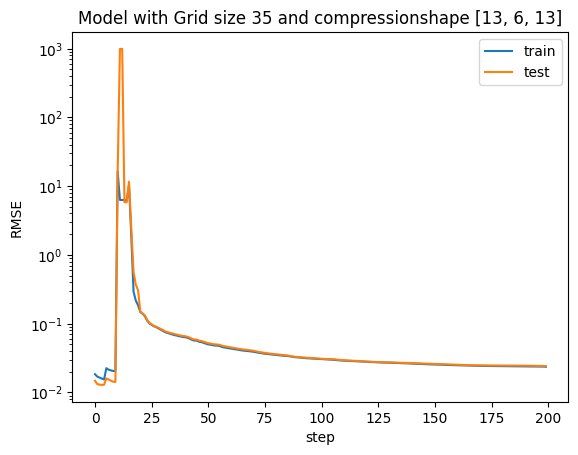

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.76e-03 | test_loss: 8.66e-03 | reg: 3.93e+01 | : 100%|█| 200/200 [07:37<00:00,  2.29


saving model version 0.1


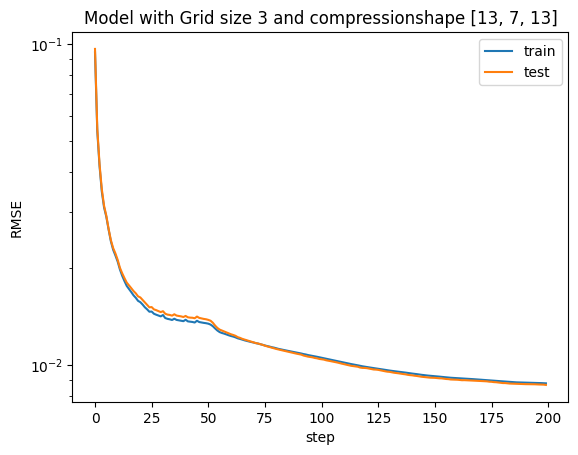

10
saving model version 0.2


| train_loss: 5.82e-03 | test_loss: 5.85e-03 | reg: 3.90e+01 | : 100%|█| 200/200 [11:14<00:00,  3.37


saving model version 0.3


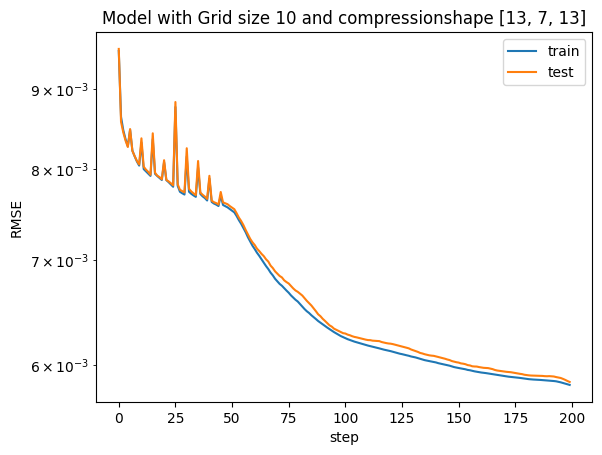

20
saving model version 0.4


| train_loss: 5.21e-03 | test_loss: 5.10e-03 | reg: 3.92e+01 | : 100%|█| 200/200 [16:32<00:00,  4.96


saving model version 0.5


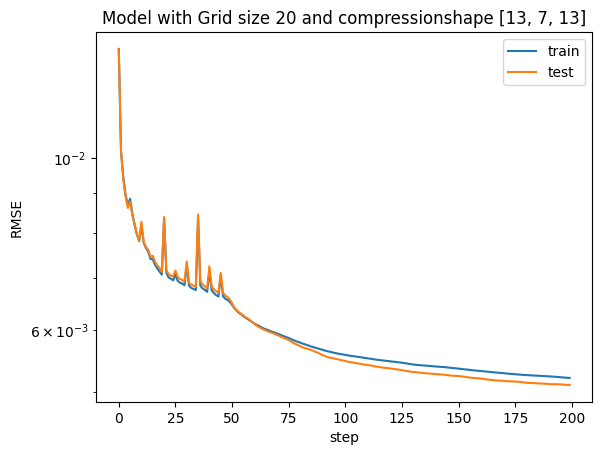

35
saving model version 0.6


| train_loss: 5.98e-03 | test_loss: 5.85e-03 | reg: 3.90e+01 | : 100%|█| 200/200 [25:45<00:00,  7.73


saving model version 0.7


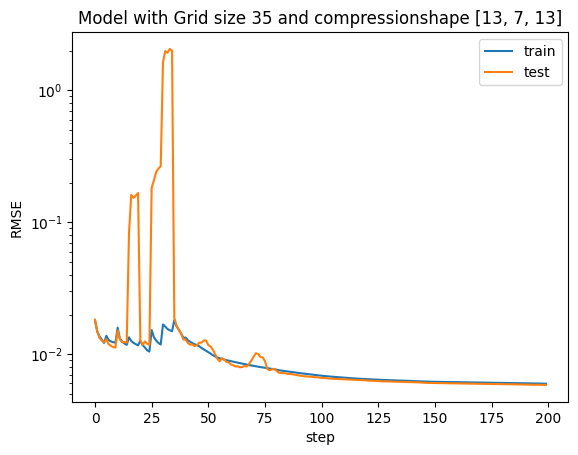

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.50e-03 | test_loss: 6.59e-03 | reg: 4.92e+01 | : 100%|█| 200/200 [08:16<00:00,  2.48


saving model version 0.1


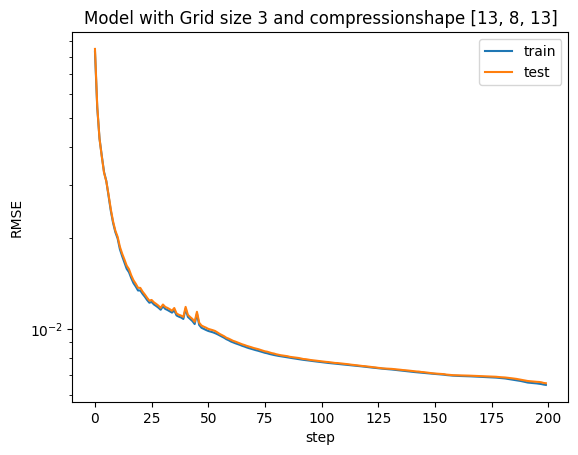

10
saving model version 0.2


| train_loss: 3.03e-03 | test_loss: 3.17e-03 | reg: 5.03e+01 | : 100%|█| 200/200 [11:52<00:00,  3.56


saving model version 0.3


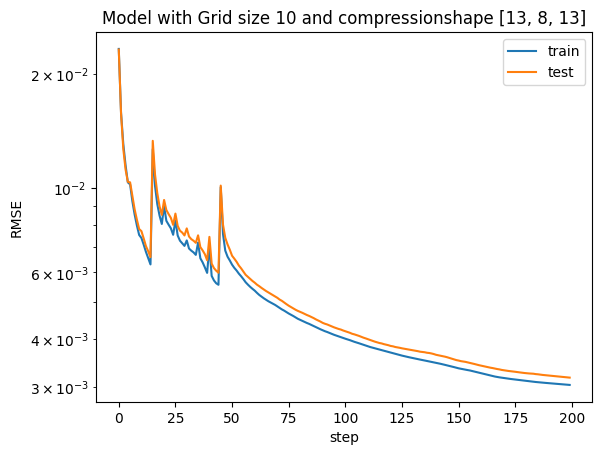

20
saving model version 0.4


| train_loss: 2.41e-03 | test_loss: 2.56e-03 | reg: 4.96e+01 | : 100%|█| 200/200 [17:47<00:00,  5.34


saving model version 0.5


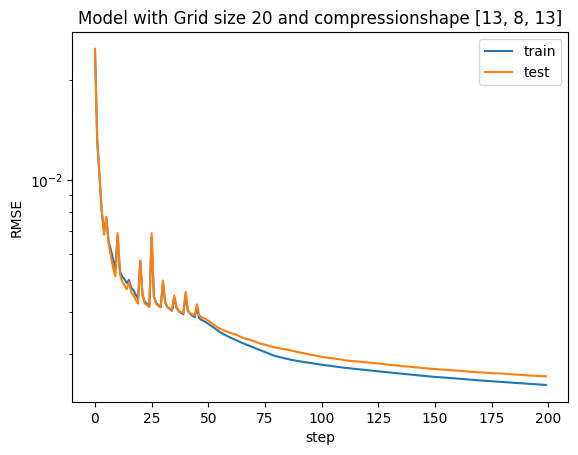

35
saving model version 0.6


| train_loss: 2.43e-03 | test_loss: 2.75e-03 | reg: 4.97e+01 | : 100%|█| 200/200 [26:45<00:00,  8.03


saving model version 0.7


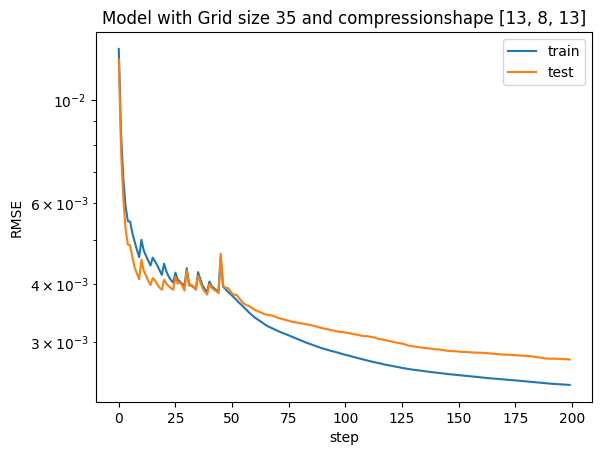

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.85e-03 | test_loss: 3.88e-03 | reg: 4.57e+01 | : 100%|█| 200/200 [09:00<00:00,  2.70


saving model version 0.1


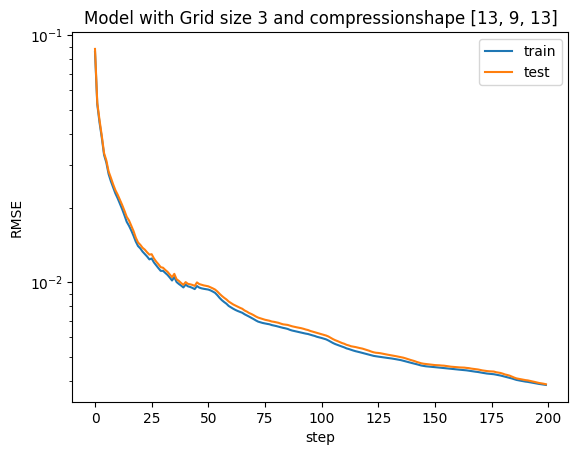

10
saving model version 0.2


| train_loss: 2.32e-03 | test_loss: 2.34e-03 | reg: 4.80e+01 | : 100%|█| 200/200 [13:22<00:00,  4.01


saving model version 0.3


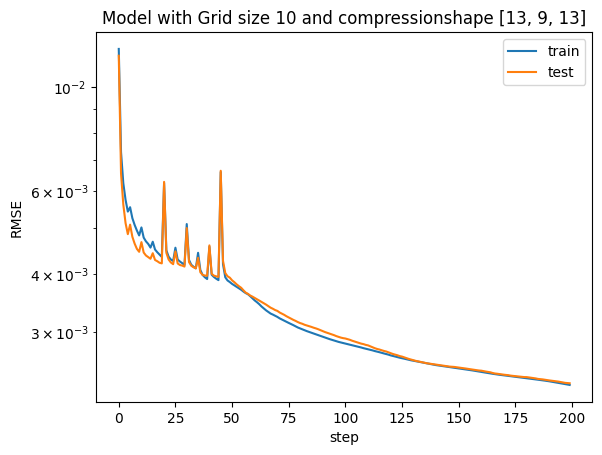

20
saving model version 0.4


| train_loss: 1.16e-03 | test_loss: 1.24e-03 | reg: 4.81e+01 | : 100%|█| 200/200 [19:29<00:00,  5.85


saving model version 0.5


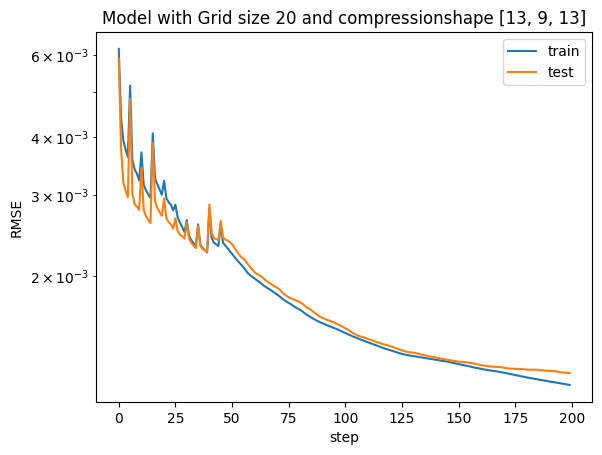

35
saving model version 0.6


| train_loss: 1.39e-03 | test_loss: 1.57e-03 | reg: 4.84e+01 | : 100%|█| 200/200 [30:15<00:00,  9.08


saving model version 0.7


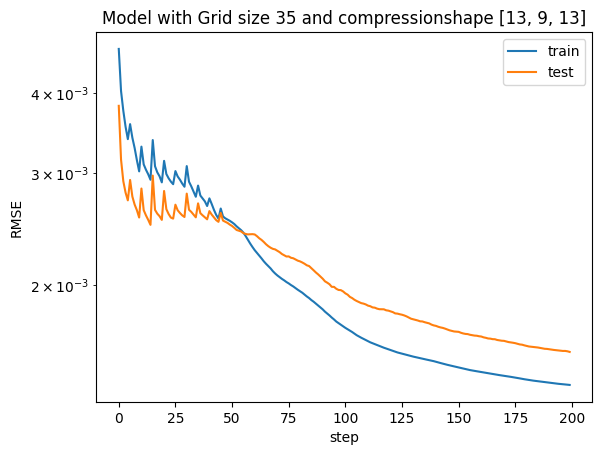

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.36e-03 | test_loss: 2.47e-03 | reg: 4.88e+01 | : 100%|█| 200/200 [09:26<00:00,  2.83


saving model version 0.1


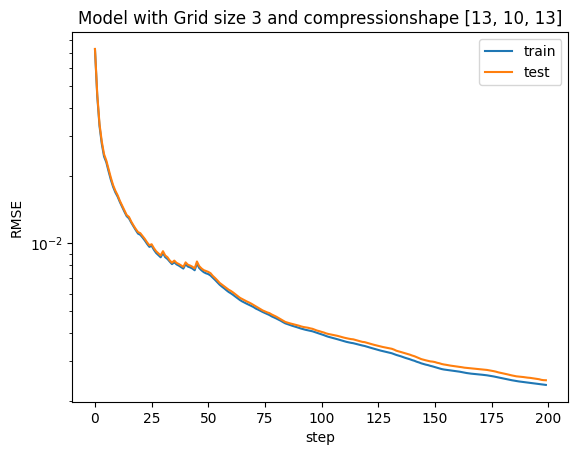

10
saving model version 0.2


| train_loss: 7.93e-04 | test_loss: 8.68e-04 | reg: 4.79e+01 | : 100%|█| 200/200 [14:15<00:00,  4.28


saving model version 0.3


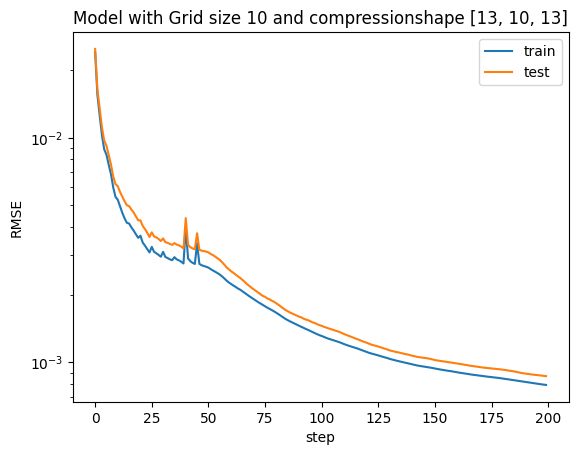

20
saving model version 0.4


| train_loss: 5.35e-04 | test_loss: 6.25e-04 | reg: 4.78e+01 | : 100%|█| 200/200 [21:10<00:00,  6.35


saving model version 0.5


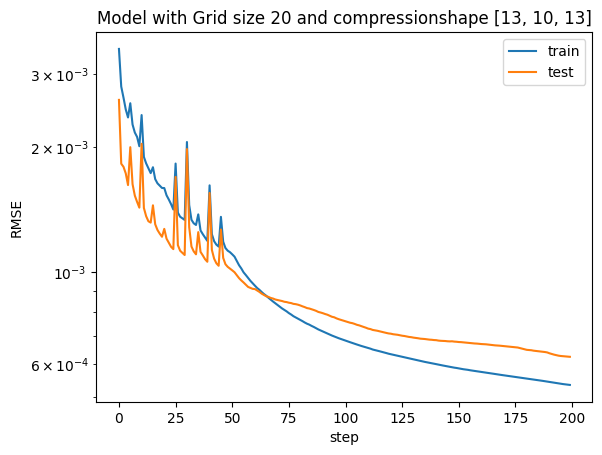

35
saving model version 0.6


| train_loss: 1.06e-03 | test_loss: 1.61e-03 | reg: 4.80e+01 | : 100%|█| 200/200 [32:21<00:00,  9.71


saving model version 0.7


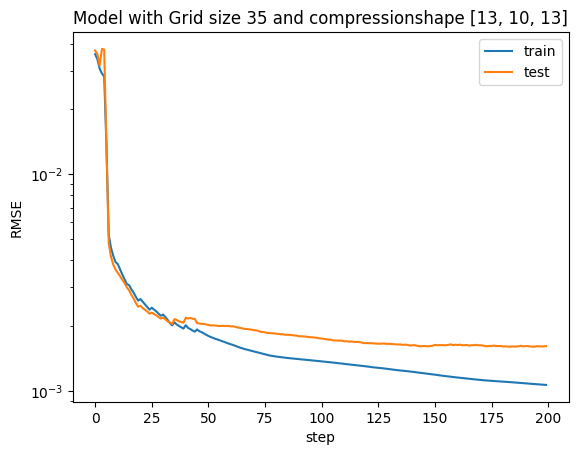

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-03 | test_loss: 1.72e-03 | reg: 5.22e+01 | : 100%|█| 200/200 [10:08<00:00,  3.04


saving model version 0.1


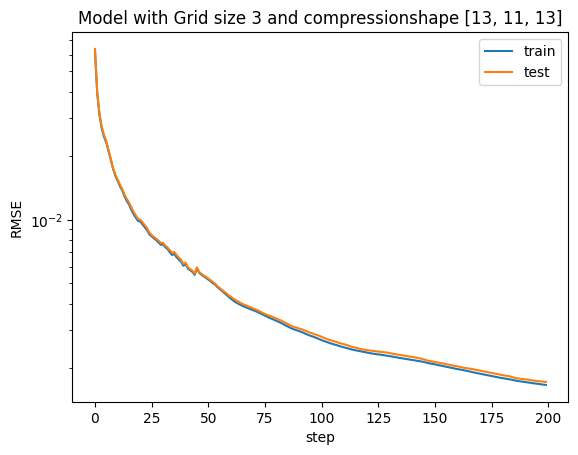

10
saving model version 0.2


| train_loss: 5.66e-04 | test_loss: 5.97e-04 | reg: 5.11e+01 | : 100%|█| 200/200 [14:54<00:00,  4.47


saving model version 0.3


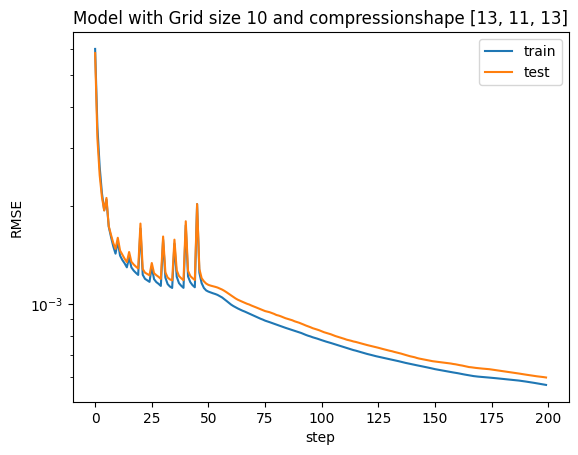

20
saving model version 0.4


| train_loss: 4.02e-04 | test_loss: 4.82e-04 | reg: 5.07e+01 | : 100%|█| 200/200 [22:28<00:00,  6.74


saving model version 0.5


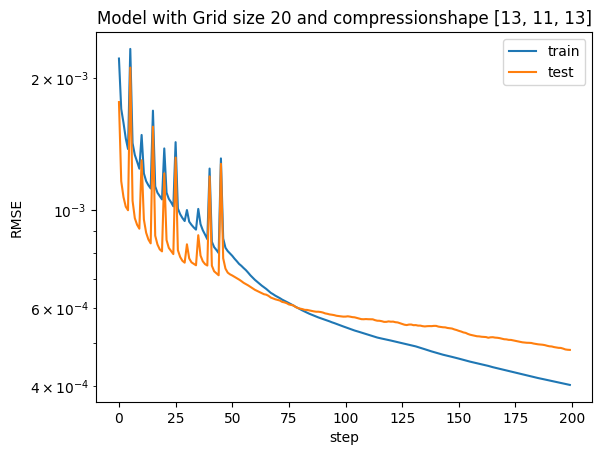

35
saving model version 0.6


| train_loss: 4.87e-03 | test_loss: 5.05e-03 | reg: 4.98e+01 | : 100%|█| 200/200 [34:17<00:00, 10.29


saving model version 0.7


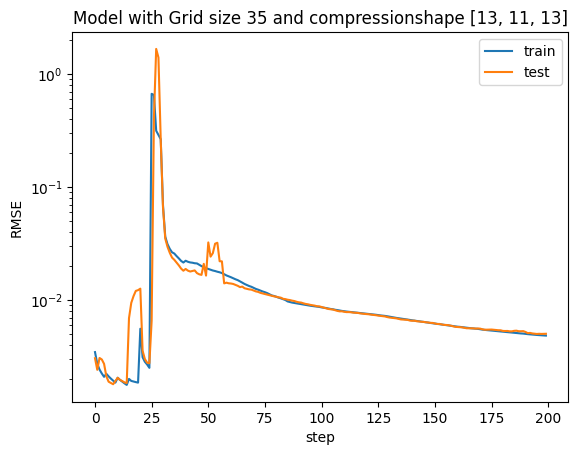

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-03 | test_loss: 1.87e-03 | reg: 5.15e+01 | : 100%|█| 200/200 [10:38<00:00,  3.19


saving model version 0.1


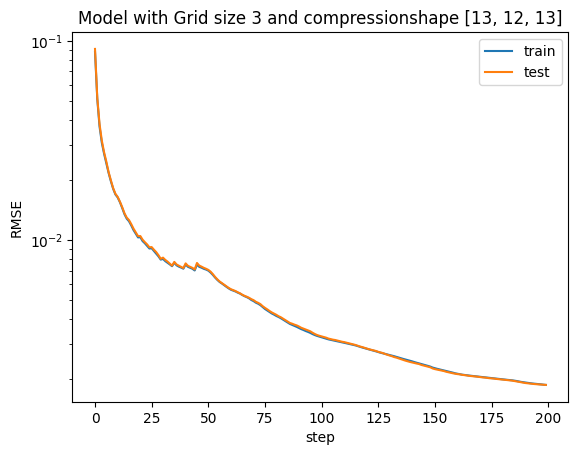

10
saving model version 0.2


| train_loss: 6.10e-04 | test_loss: 6.44e-04 | reg: 5.19e+01 | : 100%|█| 200/200 [15:55<00:00,  4.78


saving model version 0.3


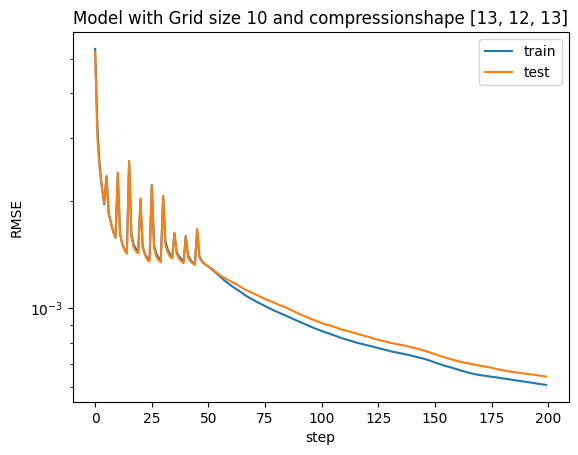

20
saving model version 0.4


| train_loss: 4.64e-04 | test_loss: 5.37e-04 | reg: 5.32e+01 | : 100%|█| 200/200 [24:37<00:00,  7.39


saving model version 0.5


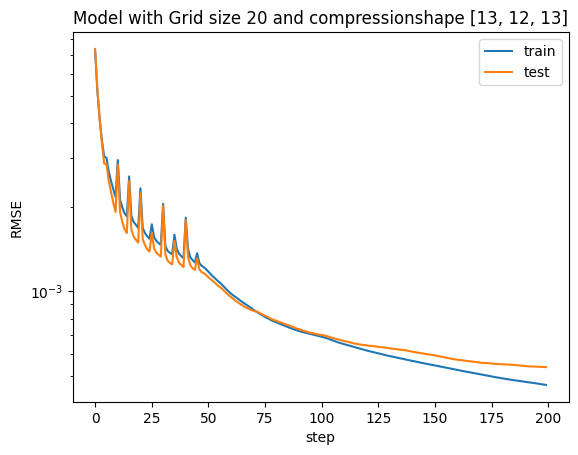

35
saving model version 0.6


| train_loss: 7.03e-04 | test_loss: 8.93e-04 | reg: 5.37e+01 | : 100%|█| 200/200 [35:51<00:00, 10.76


saving model version 0.7


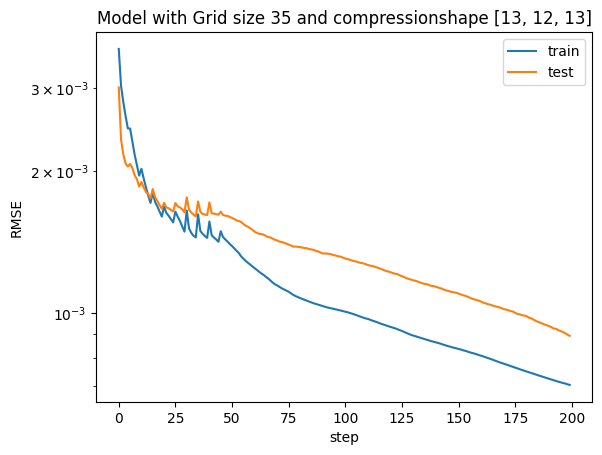

3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-03 | test_loss: 2.07e-03 | reg: 5.95e+01 | : 100%|█| 200/200 [11:36<00:00,  3.48


saving model version 0.1


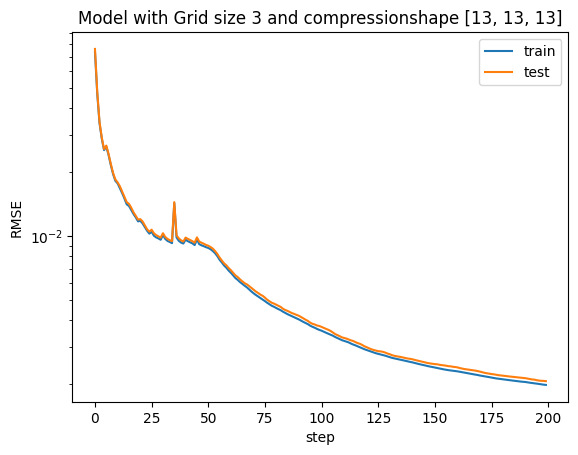

10
saving model version 0.2


| train_loss: 6.48e-04 | test_loss: 7.13e-04 | reg: 5.98e+01 | : 100%|█| 200/200 [17:39<00:00,  5.30


saving model version 0.3


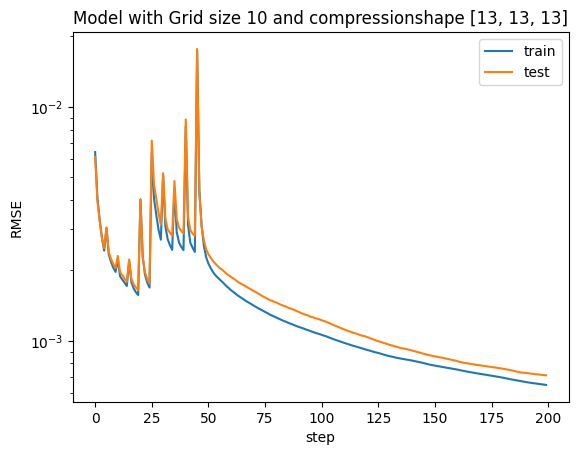

20
saving model version 0.4


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [29:29<00:00,  8.85s/it]


saving model version 0.5


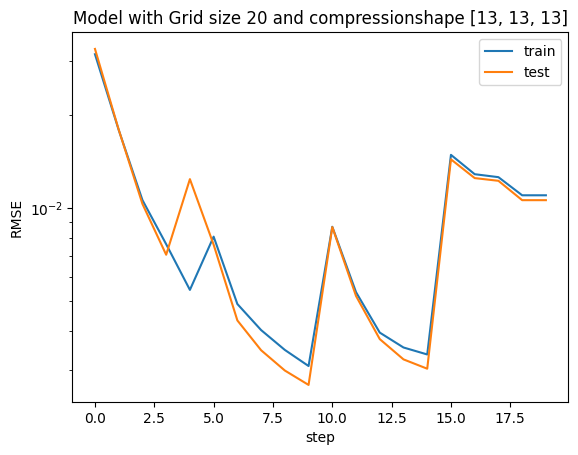

35
saving model version 0.6


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████| 200/200 [1:06:40<00:00, 20.00s/it]


saving model version 0.7


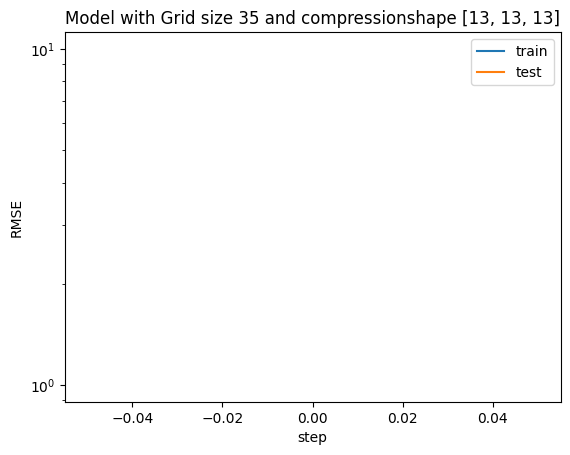

AttributeError: Can't pickle local object 'Symbolic_KANLayer.__init__.<locals>.<listcomp>.<listcomp>.<lambda>'

In [310]:
for i in range(1,14):
    #model = KAN(width=[13,i,13], grid=3, k=3, seed = 2)
    model_dict[i] = model_refinement([13,i,13], dataset=dataset)
import pickle
with open('model_dict.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

In [226]:
i = 5
#print(dataset['test_input'], model(dataset['test_input']))
#max(torch.linalg.norm(dataset['test_input'] - model(dataset['test_input']).detach(), axis = 1))
print(torch.max(dataset['test_input'] - model(dataset['test_input']).detach()))
print(torch.where(dataset['test_input'] - model(dataset['test_input']).detach() > 0.2))

print(dataset['test_input'][i] - model(dataset['test_input']).detach()[i])

tensor(0.5366)
(tensor([   5,    6,   19,   43,  126,  244,  262,  385,  415,  581, 1019, 1053,
        1064, 1068, 1109, 1141, 1317, 1388, 1425, 1551, 1572, 1600, 1646, 1657,
        1720]), tensor([6, 0, 5, 5, 2, 2, 9, 0, 2, 5, 9, 0, 2, 5, 6, 2, 5, 2, 2, 5, 2, 2, 6, 2,
        2]))
tensor([-0.0010,  0.0313,  0.0039,  0.0175,  0.1031,  0.0129,  0.2048,  0.0788,
         0.0696,  0.0385,  0.0246, -0.0266, -0.0011])
